Dependencies for this notebook to run. 

# CGM Blood Glucose forecasting
### Ricco Ferraro 

In [ ]:
!pip install pyyaml==5.4.1
!pip install darts
!pip install matplotlib==3.1.3

In [1]:
import random
import joblib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import cpu_count, Pool # for prophet
import statistics
import time
from itertools import product
import os
from statsmodels.tsa.ar_model import AutoReg
from datetime import datetime as dt
from datetime import timedelta, timezone
from scipy.signal import lombscargle, periodogram
import darts
from darts.metrics import mape
from darts import TimeSeries
from darts.utils import timeseries_generation as tg
from darts.models import AutoARIMA
from darts.models import KalmanFilter, TCNModel, NBEATSModel
from darts.utils.statistics import extract_trend_and_seasonality, plot_hist, check_seasonality, plot_acf
import torch
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# GOAL: 
Come up with a glucose prediction algorithm that predicts glucose levels at 30 minutes into the future. 

# The Data

The Data used in this analysis is Continuous Glucose Monitoring Data collected in a Randomized Trial meant to compare CGM with and with and without Routine Blood Glucose monitoring. Specifically, the CGM data we use in this analysis was collected via the Dexcom G4 Platinum Continuous Glucose Monitoring System. It is deidentified and is publicly available here: https://public.jaeb.org/datasets/diabetes as the "Replace-BG-Dataset.zip". A link for download is here: https://public.jaeb.org/datasets/diabetes#:~:text=REPLACE%2DBG%20Dataset.zip  






Pull in the data:

*Developer/Scientist Note: I used `Google Colab` for this analysis due to its access to hardware like NVidea GPU's and TPU's.*


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_path = "/content/drive/MyDrive/Colab Notebooks/glucose_prediction/data"
HDeviceCGM = pd.read_csv(f"{data_path}/HDeviceCGM.txt", sep='|', index_col=False) 

In [ ]:
print(HDeviceCGM.describe())
print(len(HDeviceCGM))

              RecID  ParentHDeviceUploadsID          PtID        SiteID  \
count  1.495066e+07            1.495066e+07  1.495066e+07  1.495066e+07   
mean   7.616951e+06            5.784978e+03  1.477633e+02  8.276100e+00   
std    4.447060e+06            3.168884e+03  8.531525e+01  4.412503e+00   
min    1.000000e+00            4.000000e+00  2.000000e+00  1.000000e+00   
25%    3.737666e+06            3.022000e+03  7.200000e+01  5.000000e+00   
50%    7.475331e+06            5.966000e+03  1.470000e+02  8.000000e+00   
75%    1.151821e+07            8.652000e+03  2.230000e+02  1.200000e+01   
max    1.525588e+07            1.104000e+04  2.930000e+02  1.500000e+01   

       DeviceDtTmDaysFromEnroll  DexInternalDtTmDaysFromEnroll  GlucoseValue  
count              1.495066e+07                   1.435789e+07  1.495066e+07  
mean               1.070591e+02                   9.752153e+01  1.603617e+02  
std                8.177121e+01                   1.007653e+02  6.467256e+01  
min     

Here we can see already that we are dealing with a lot of data. ~900MB to be specific. 

In [ ]:
HDeviceCGM.dtypes

RecID                              int64
ParentHDeviceUploadsID             int64
PtID                               int64
SiteID                             int64
DeviceDtTmDaysFromEnroll           int64
DeviceTm                          object
DexInternalDtTmDaysFromEnroll    float64
DexInternalTm                     object
RecordType                        object
GlucoseValue                     float64
dtype: object

In [ ]:
print(HDeviceCGM['GlucoseValue'].isnull().any())
print(HDeviceCGM['DeviceDtTmDaysFromEnroll'].isnull().any())
print(HDeviceCGM['DeviceTm'].isnull().any())

False
False
False


In [ ]:
HDeviceCGM.head(10)

,RecID,ParentHDeviceUploadsID,PtID,SiteID,DeviceDtTmDaysFromEnroll,DeviceTm,DexInternalDtTmDaysFromEnroll,DexInternalTm,RecordType,GlucoseValue
0,1655236,782,183,12,-6,05:35:41,-6.0,12:37:02,CGM,162.0
1,1655237,782,183,12,-6,05:30:41,-6.0,12:32:02,CGM,164.0
2,1655238,782,183,12,-6,05:25:41,-6.0,12:27:02,CGM,168.0
3,1655239,782,183,12,-6,05:20:41,-6.0,12:22:02,CGM,169.0
4,1655240,782,183,12,-6,05:15:41,-6.0,12:17:02,CGM,170.0
5,1655241,782,183,12,-6,05:10:41,-6.0,12:12:02,CGM,171.0
6,1655242,782,183,12,-6,05:05:41,-6.0,12:07:02,CGM,172.0
7,1655243,782,183,12,-6,05:00:42,-6.0,12:02:02,CGM,174.0
8,1655244,782,183,12,-6,04:55:41,-6.0,11:57:02,CGM,177.0
9,1655245,782,183,12,-6,04:50:41,-6.0,11:52:02,CGM,180.0


## Normalizing the data

In [3]:
# helpers
patient_ids = [183, 184,  14, 220, 233,  62,  17, 186,  52, 216, 115,  37, 244,
       167, 265,  81, 113, 248,  76,  21,  79, 132, 215, 223, 110,  19,
       260, 289,  54,  64, 232, 172,  45, 203, 119,  31,  24, 156, 276,
       162, 240, 239,  32, 236,  73,  26, 205,  48, 267,   2, 256, 141,
         8,  22, 204, 163,  42, 226, 251, 198, 165,  60, 264, 241, 138,
        67,  90, 206,  38, 266, 281,  10,  41, 185,  35, 140, 283, 118,
        80, 123, 217,  39, 160, 112,  50, 292, 164, 246,  18, 128, 103,
       210,   9,  71, 169,  65, 166,  74,  96, 134, 271,  55, 228, 234,
       155, 139,  95,   7,  11,  61, 250, 168, 108, 252, 106,  68, 213,
       127,  36, 176, 273, 130, 136, 152,  53, 193, 243, 253, 148, 135,
       274, 287, 231, 105, 201,   3, 200, 245,  91,  98, 101, 137,  70,
       219, 121, 143,  23, 109, 263,  46, 229,  93, 188,  72, 190, 211,
       218,  77, 181, 288, 278,  87, 173,  47,  33, 277, 224,  43, 257,
        69, 175,  58, 124,  78, 116, 146,  49,  30,  16,  86,   5, 158,
       171, 179, 258, 284, 170, 147, 249,  97, 131, 272, 285, 174, 222,
       102, 221,  15,  89,  57,  82,  29, 214, 149, 227,  20, 280, 247,
       269, 157,  40, 293, 145, 197,  27, 187, 254, 235, 209, 129, 177,
       291, 189, 290, 275, 111]
def downcast_to_float_32(df):
    df['GlucoseValue'] = df['GlucoseValue'].astype(np.float32)
    df['TotalDeviceMinutes'] = df['TotalDeviceMinutes'].astype(np.float32)
    df['TotalInternalHours_Diff'] = df['TotalInternalHours_Diff'].astype(np.float32)
    return df

def get_all_resampled_patient_timeseries(patient_dfs, value_column = "GlucoseValue"):
  all_patient_timeseries = []
  for df in patient_dfs: 
    individual_patient_timeseries = TimeSeries.from_dataframe(df, value_cols = [value_column]) 
    all_patient_timeseries.append(individual_patient_timeseries)
  return all_patient_timeseries

def get_resampled_patient_dfs(): 
  resampled_patient_dfs = []
  for patient_id in patient_ids:
    # patient_ids less than ten lead with 0, eg: 01
    patient_id_string = f'0{patient_id}' if patient_id < 10 else str(patient_id)
    df = pd.read_hdf(f'{data_path}/resampled/patient_df_{patient_id_string}.h5')  
    df = downcast_to_float_32(df)
    resampled_patient_dfs.append(df)
  return resampled_patient_dfs

### Time Stamps
We can see that the data has a `GlucoseValue` column and that the sampling interval for the CGM was roungly 5 minutes between samples. There is a `PtID` column which uniquely identifies each patient by patient id. (anonymously). 

We can also see that the first thing we need to do is to add a unique `DeviceDateTime` and `TotalDeviceMinutes` to every record, so that we can uniquely identify patient's specific CGM timeseries data.  

This is accomplished by merging the `DeviceTm` and `DeviceDtTmDaysFromEnroll` columns for each unique patient. For more detail on this data preprocessing step, please see the `./PreProcessTimestamp.ipynb` notebook. 

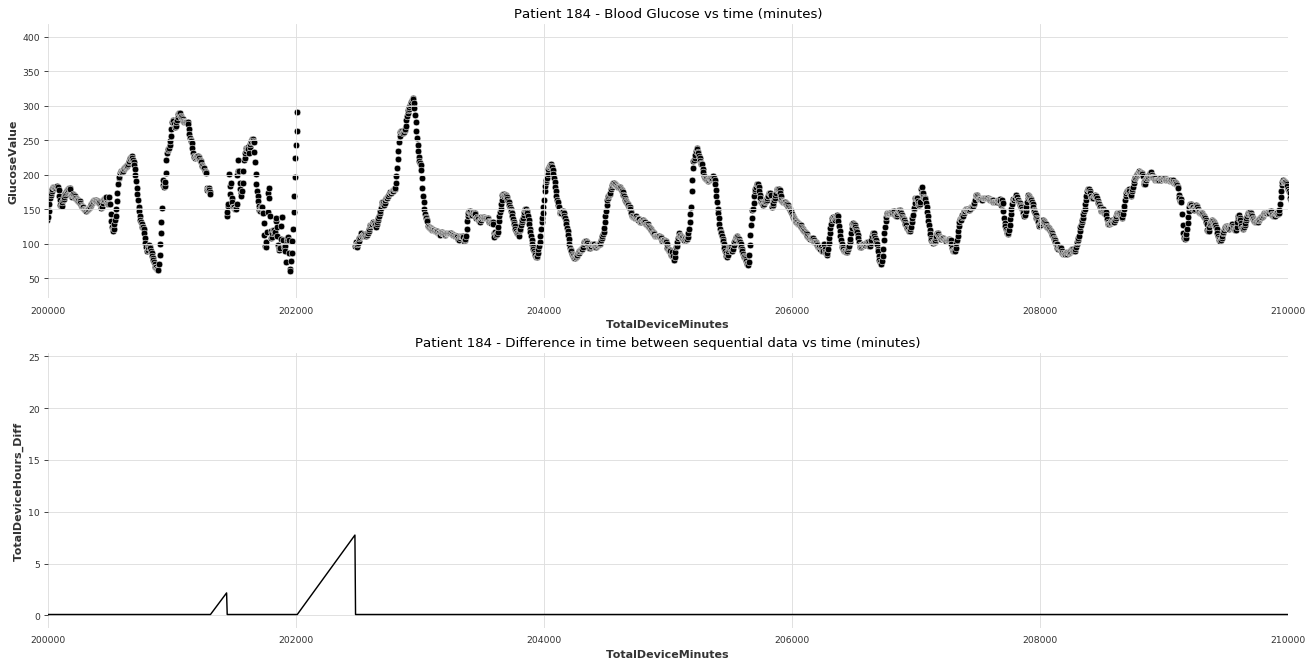

In [20]:
df_example_timestamp_added_pt184 = pd.read_hdf(f"{data_path}/timestamp/patient_df_184.h5")  
df_example_timestamp_added_pt184['TotalDeviceHours_Diff'] = abs(df_example_timestamp_added_pt184['TotalDeviceMinutes'].diff() / 60)

fig, axes = plt.subplots(2,1, figsize=(20,10), dpi=80)
axes[0].set_title("Patient 184 - Blood Glucose vs time (minutes)")
axes[0].set_xlim(200000, 210000)
sns.scatterplot(data=df_example_timestamp_added_pt184, x="TotalDeviceMinutes", y="GlucoseValue", ax=axes[0])

axes[1].set_title("Patient 184 - Difference in time between sequential data vs time (minutes)")
axes[1].set_xlim(200000, 210000)
sns.lineplot(data=df_example_timestamp_added_pt184, x="TotalDeviceMinutes", y="TotalDeviceHours_Diff", ax=axes[1])

### Sampling Rate
The problem: 
As can be seen above, there are gaps in patient cgm data. This could be because a CGM was disconected or for some other reason. Additionally, the data is close to being sampled at 5 minutes for every sample, but as can be seen in the following plot, there are definitely times when the sample rate for the data is not normalized or constant. 

Solution: 
1. First, to ensure high quality data, find the longest Contiguous chunk of samples, per patient, for  which all samples are closer than 1.5 hours together in time. 

2. Second, re-sample the data at 30 minute intervals, performing a spline interpolation where necessary. 

For more on how this was done please see `./PreProcessResample.ipynb`


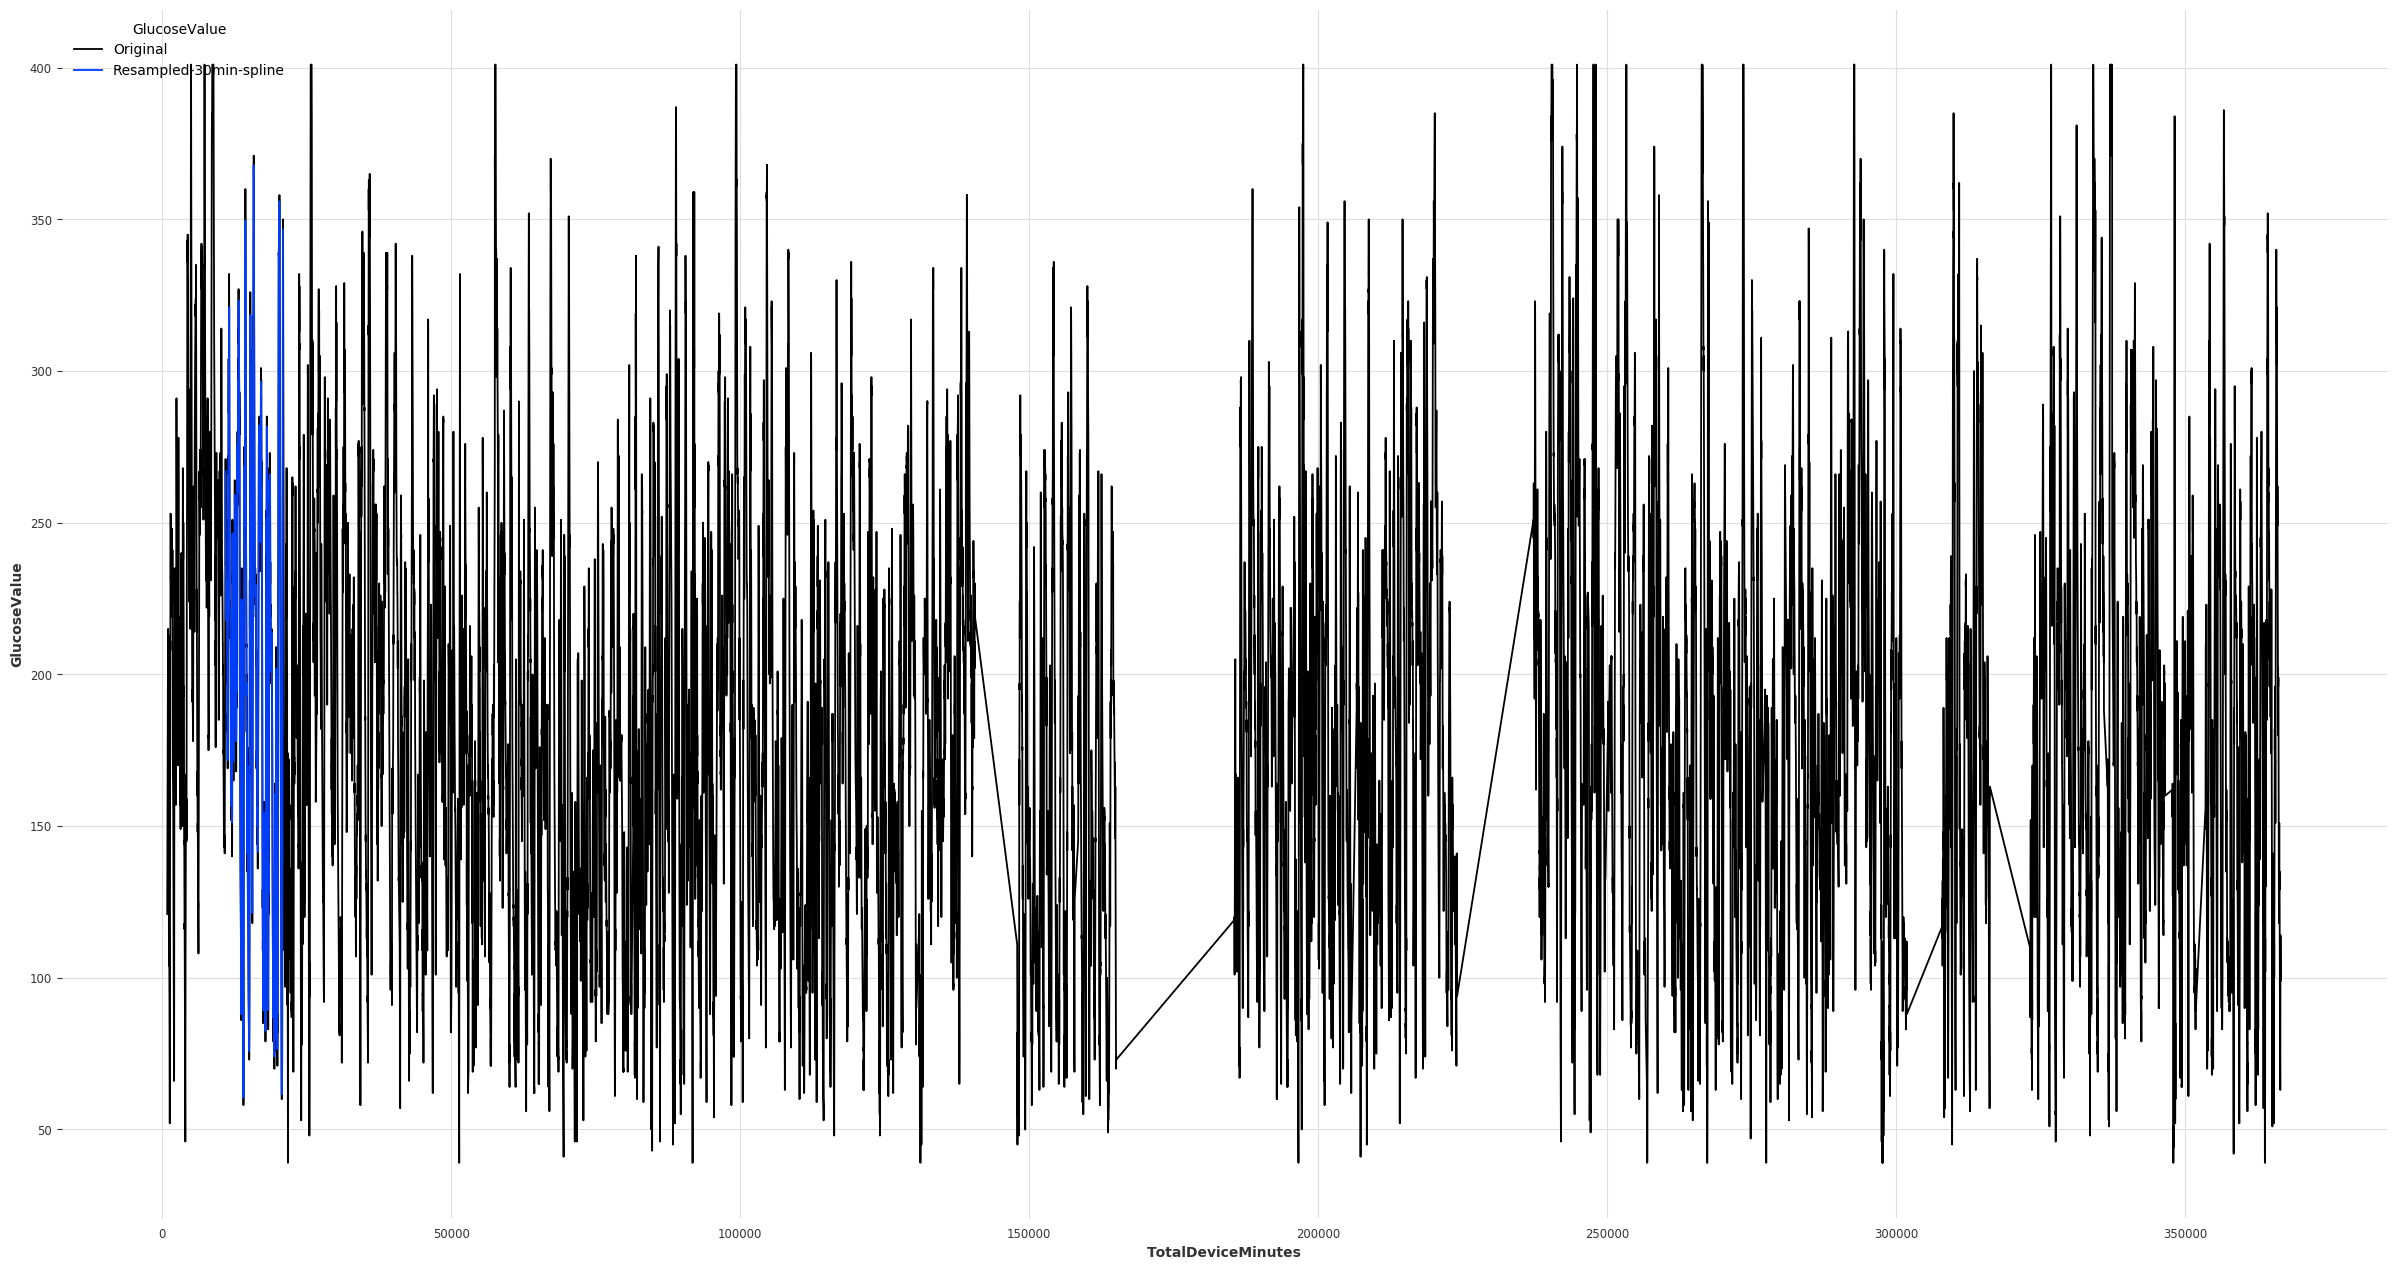

In [26]:
# examples of the smoothed data from resampling...
df_example_timestamp_added = pd.read_hdf(f"{data_path}/timestamp/patient_df_{patient_ids[5]}.h5")
resampled_patient_dfs = get_resampled_patient_dfs()
resampled_patient_dfs = resampled_patient_dfs

fig, ax = plt.subplots(1,1, figsize=(30,16), dpi=100)
df_183_filtered_length = len(resampled_patient_dfs[5])
sns.lineplot(data=df_example_timestamp_added, x="TotalDeviceMinutes", y="GlucoseValue", ax = ax)
sns.lineplot(data=resampled_patient_dfs[5], x="TotalDeviceMinutes", y="GlucoseValue", ax = ax)
plt.legend(title='GlucoseValue', loc='upper left', labels=['Original', 'Resampled-30min-spline'])

As we can see above, the longest subsequences are selected from the original timeseries data. 

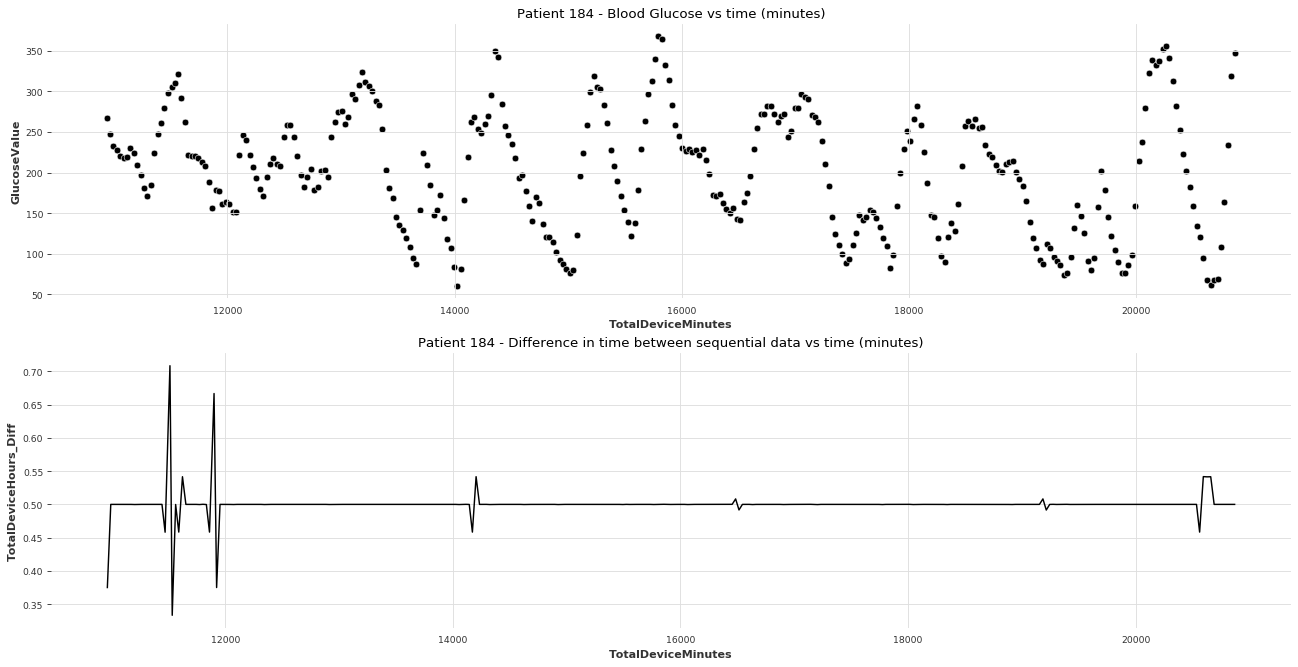

In [27]:
df_example_timestamp_added_copy = resampled_patient_dfs[5].copy()
df_example_timestamp_added_copy['TotalDeviceHours_Diff'] = abs(df_example_timestamp_added_copy['TotalDeviceMinutes'].diff() / 60)

fig, axes = plt.subplots(2,1, figsize=(20,10), dpi=80)
axes[0].set_title("Patient 184 - Blood Glucose vs time (minutes)")
sns.scatterplot(data=df_example_timestamp_added_copy, x="TotalDeviceMinutes", y="GlucoseValue", ax=axes[0])

axes[1].set_title("Patient 184 - Difference in time between sequential data vs time (minutes)")
sns.lineplot(data=df_example_timestamp_added_copy, x="TotalDeviceMinutes", y="TotalDeviceHours_Diff", ax=axes[1])

In the above plot we an see the longest subsequence with the differenc in sequential time. Note that there are no large gaps between any timepoints. 

# EDA
Now that our data has been processed into contiguous chunks and evenly sampled, lets explore some characteristics of it. 

In [6]:
# resampled data 
resampled_patient_dfs = get_resampled_patient_dfs()
# use 50/50 for test/train split for now. Split by entire timeseries!
train_cutoff_index = round(len(resampled_patient_dfs)/2)

# dfs
resampled_patient_dfs_train = resampled_patient_dfs[:train_cutoff_index]
resampled_patient_dfs_test = resampled_patient_dfs[train_cutoff_index:]

# time-series
resampled_patient_timeseries_train = get_all_resampled_patient_timeseries(resampled_patient_dfs_train, "GlucoseValue")
resampled_patient_timeseries_test = get_all_resampled_patient_timeseries(resampled_patient_dfs_test, "GlucoseValue")

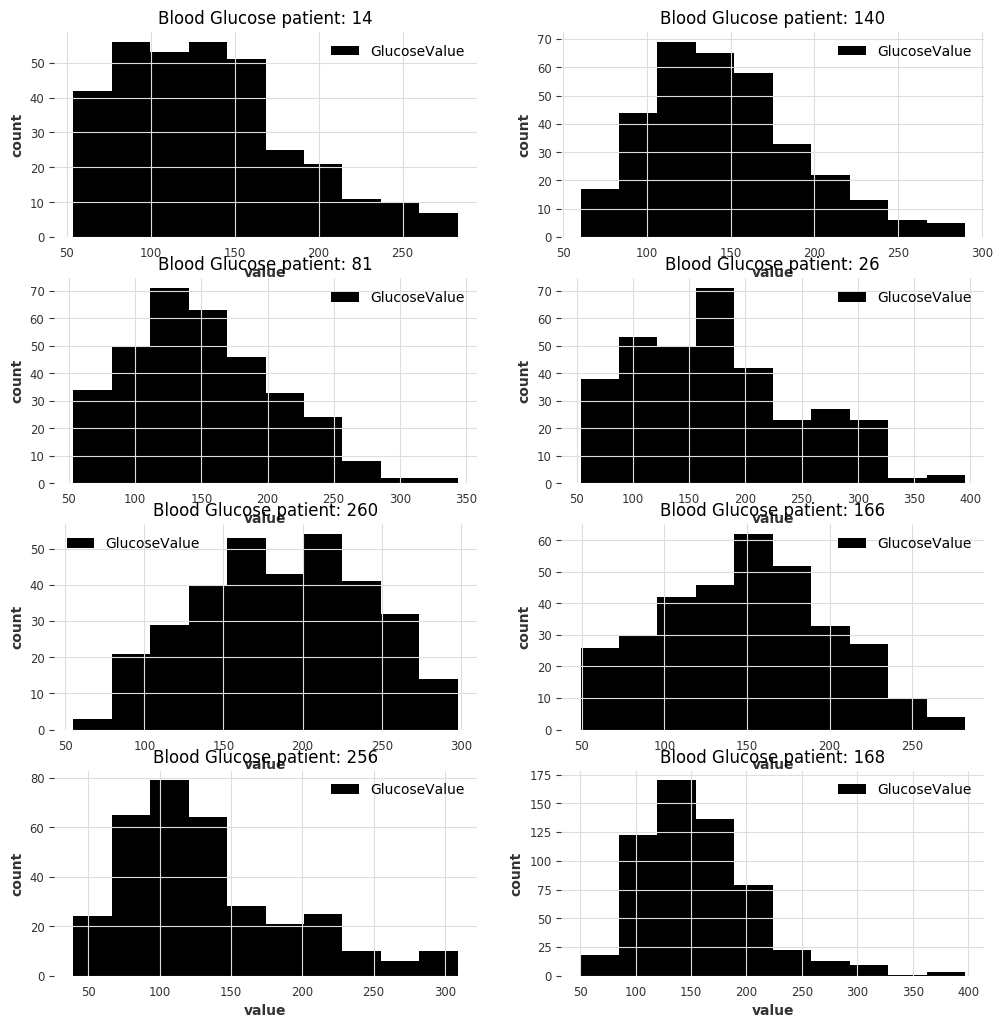

In [29]:
# plot some blood glucose distributions - TODO: ADD this to EDA Notebook!
fig, axes = plt.subplots(4,2, figsize=(12,12.5), dpi=100)
plot_hist(resampled_patient_timeseries_train[2], title = f"Blood Glucose patient: {patient_ids[2]}", ax=axes[0, 0])
plot_hist(resampled_patient_timeseries_train[15], title = f"Blood Glucose patient: {patient_ids[15]}", ax=axes[1, 0])
plot_hist(resampled_patient_timeseries_train[26], title = f"Blood Glucose patient: {patient_ids[26]}", ax=axes[2, 0])
plot_hist(resampled_patient_timeseries_train[50], title = f"Blood Glucose patient: {patient_ids[50]}", ax=axes[3, 0])
plot_hist(resampled_patient_timeseries_train[75], title = f"Blood Glucose patient: {patient_ids[75]}", ax=axes[0, 1])
plot_hist(resampled_patient_timeseries_train[45], title = f"Blood Glucose patient: {patient_ids[45]}", ax=axes[1, 1])
plot_hist(resampled_patient_timeseries_train[96], title = f"Blood Glucose patient: {patient_ids[96]}", ax=axes[2, 1])
plot_hist(resampled_patient_timeseries_train[111], title = f"Blood Glucose patient: {patient_ids[111]}", ax=axes[3, 1])

We can see that there are different distributions of values per patient. However, on average glucose does appear to right skewed. This might suggest a log transform to be useful. The skew doesn't appear to be extreme though. To keep things simple, and more interpretable, lets leave the glucose values alone (no transform).



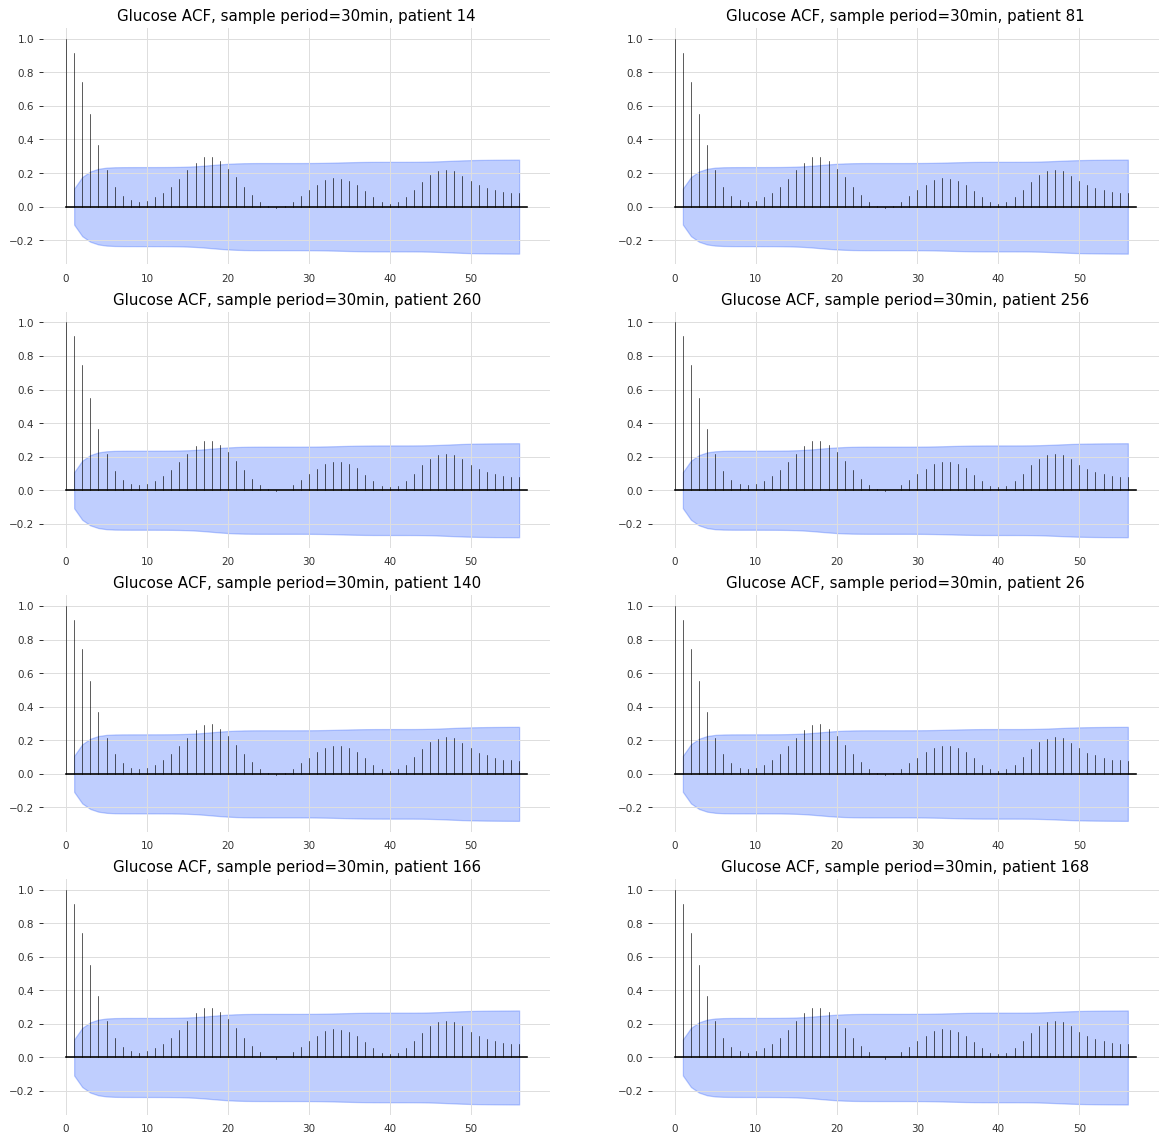

In [34]:
# plot some blood glucose acf's
fig, axes = plt.subplots(4,2, figsize=(16,16), dpi=90)
patient_id_indices = [2, 15, 26, 50, 75, 45, 96, 111]

for patient_id_index, (idx, idy) in zip(patient_id_indices, product(range(4), range(2))): 
  axes[idx, idy].set_title(f"Glucose ACF, sample period=30min, patient {patient_ids[patient_id_index]}")
  plot_acf(resampled_patient_timeseries_train[2], axis=axes[idx, idy], max_lag=56)

We can see that there is some wandering, but also some periodicity (at varying periods) across the various glucose time-series. This probably reflects the varying meal frequency of different patients. We can also use domain knowledge to assume that, while there is strong positive correlation between glucose values (for at least 2 hours), values will never wander beyond 400 (the upper CGM limit) and below 0. We also know that glucose values depend heavily on indidual meals and insulin dosing, thus we can assume that each patient realization will be random WRT to one another (not predictable, like a sine wave).

 As far as seasonality, we can it is reasonable to expect either a rough ~24 hour seasonality (daily meal seasonality) or even a ~3 hour seasonality (between meals). 

# Models
In order to predict glucose 30 minutes out, we build a series of models capable of causaly using past or current glucose values (univariately) to predict 30 minutes out at any given time. 

In [7]:
# load resampled data 

resampled_patient_dfs = get_resampled_patient_dfs()
# use 50/50 for test/train for now
train_cutoff_index = round(len(resampled_patient_dfs)/2)

# dfs
resampled_patient_dfs_train = resampled_patient_dfs[:train_cutoff_index]
resampled_patient_dfs_test = resampled_patient_dfs[train_cutoff_index:]

# time-series
resampled_patient_timeseries_train = get_all_resampled_patient_timeseries(resampled_patient_dfs_train, "GlucoseValue")
resampled_patient_timeseries_test = get_all_resampled_patient_timeseries(resampled_patient_dfs_test, "GlucoseValue")

## No-Information Prediction: 
Using the current value to predict the next 30 minutes. For a detailed analysis of this predictor please see: `./LastValueModel.ipynb`



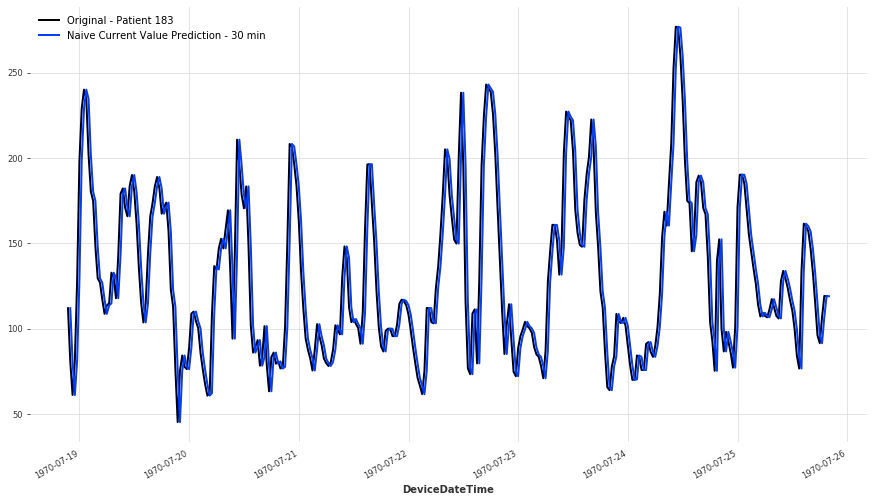

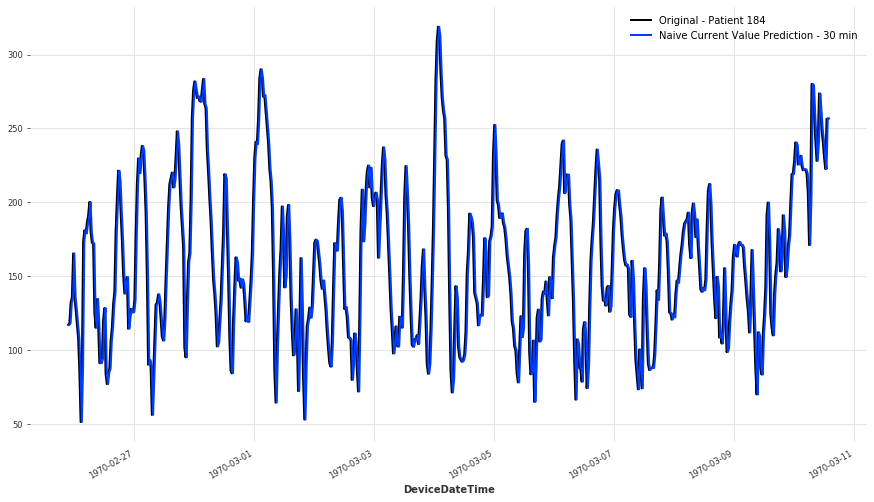

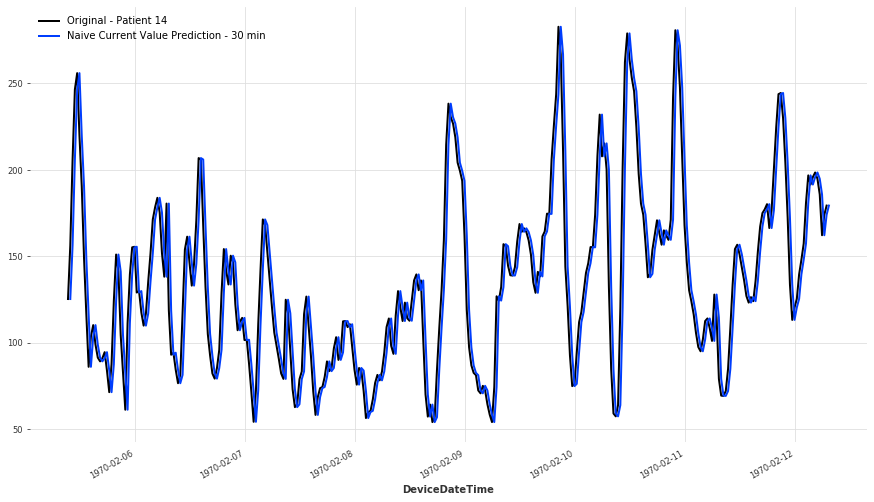

In [38]:
index = 0 
for patient_id_index in range(0, 3):
  plt.figure(figsize=(15,8))
  plt.title("Naive Current Value Prediction")
  resampled_patient_timeseries_train[patient_id_index].plot(label=f"Original - Patient {patient_ids[patient_id_index]}")
  resampled_patient_timeseries_train[patient_id_index].shift(n=1).plot(label="Naive Current Value Prediction - 30 min")

As can be seen above, the Naive-30 min prediction of glucose value, by simply predicting the it be the current value, has a fairly good mean absolute percentage error at `12.094%`. It also requires NO training of ANY model. This will probably be hard to beat for many algorithms and serves as a strong "no information" prediction. This makes sense, because we have decently high positive correlation between our data for lags of 30min or even 1hr.

## SARIMA

In a traditional ARIMA/SARIMA univariate analyis (for more detail please see `./ARIMA.ipynb`) SARIMA is explored as another forecasting model for 30 minute blood glucose. 

To do this, we first explored overfitting AR factor. 

In [39]:
for i in range(0,4):
  print("==================================")
  print(f"========== OVERFIT AR - Model {i} =====")
  print("==================================")
  overfit_ar_model = AutoReg(resampled_patient_dfs_train[i]['GlucoseValue'], lags=50).fit()
  print(overfit_ar_model.summary())

========== OVERFIT AR - Model 0 =====
                            AutoReg Model Results                             
Dep. Variable:           GlucoseValue   No. Observations:                  333
Model:                    AutoReg(50)   Log Likelihood               -1160.750
Method:               Conditional MLE   S.D. of innovations             14.624
Date:                Thu, 05 May 2022   AIC                           2425.500
Time:                        09:43:05   BIC                           2615.063
Sample:                    07-19-1970   HQIC                          2501.508
                         - 07-25-1970                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               26.3595     10.136      2.601      0.009       6.494      46.225
GlucoseValue.L1      1.5782      0.058     27.011      0.000       1.464   

It appears that there are MANY factors with roots outside the unit circle which dominate in the signal. As expected, none of these have a system frequency of 0, which backs up our domain driven assumption that glucose values CANNOT wander outside of certain values (for someone who is still alive). 

Further and surprisingly, the MOST dominant roots for each training patient glucose timeseries,  all seem to share system frequencies of 0.5. This suggests pure oscillation in the signal. My hunch is that there is seasonality, and that it is a higher order seasonality which is composed of common factors.

The takeaway here is that the data does NOT appear stationary due to seasonality present in the data (personal meal patterns exist!).

Next we fit an AutoARIMA with "bic" to identify the phi, theta, s, & d, preferring a parsimonous model. We then evaluated that ARIMA model against 5 different patient time series datasets computing the Mean Absolute Percentage Error (MAPE). 

We note that for the the first SARIMAX (SARIMAX 0) the  Ljung-Box residual test for whitenoise, CAN reject the possibility of the residuals being white noise. As such, correlation is still present in the data. HOWEVER, forthe next glucose timeseries (SARIMAX 1), we CANNOT reject whitenoise in the residuals, suggesting correlation entropy has been effectively captured. This suggests that the best SARIMA for each patient varies somewhat signifigantly.  

Ultimately, the arima which emerged as the best for its dataset was SARIMA(1, 0, 1). This is good in that it is very simple with the prediction depending on 86% of the previous value with a moving average correlation to noise.  


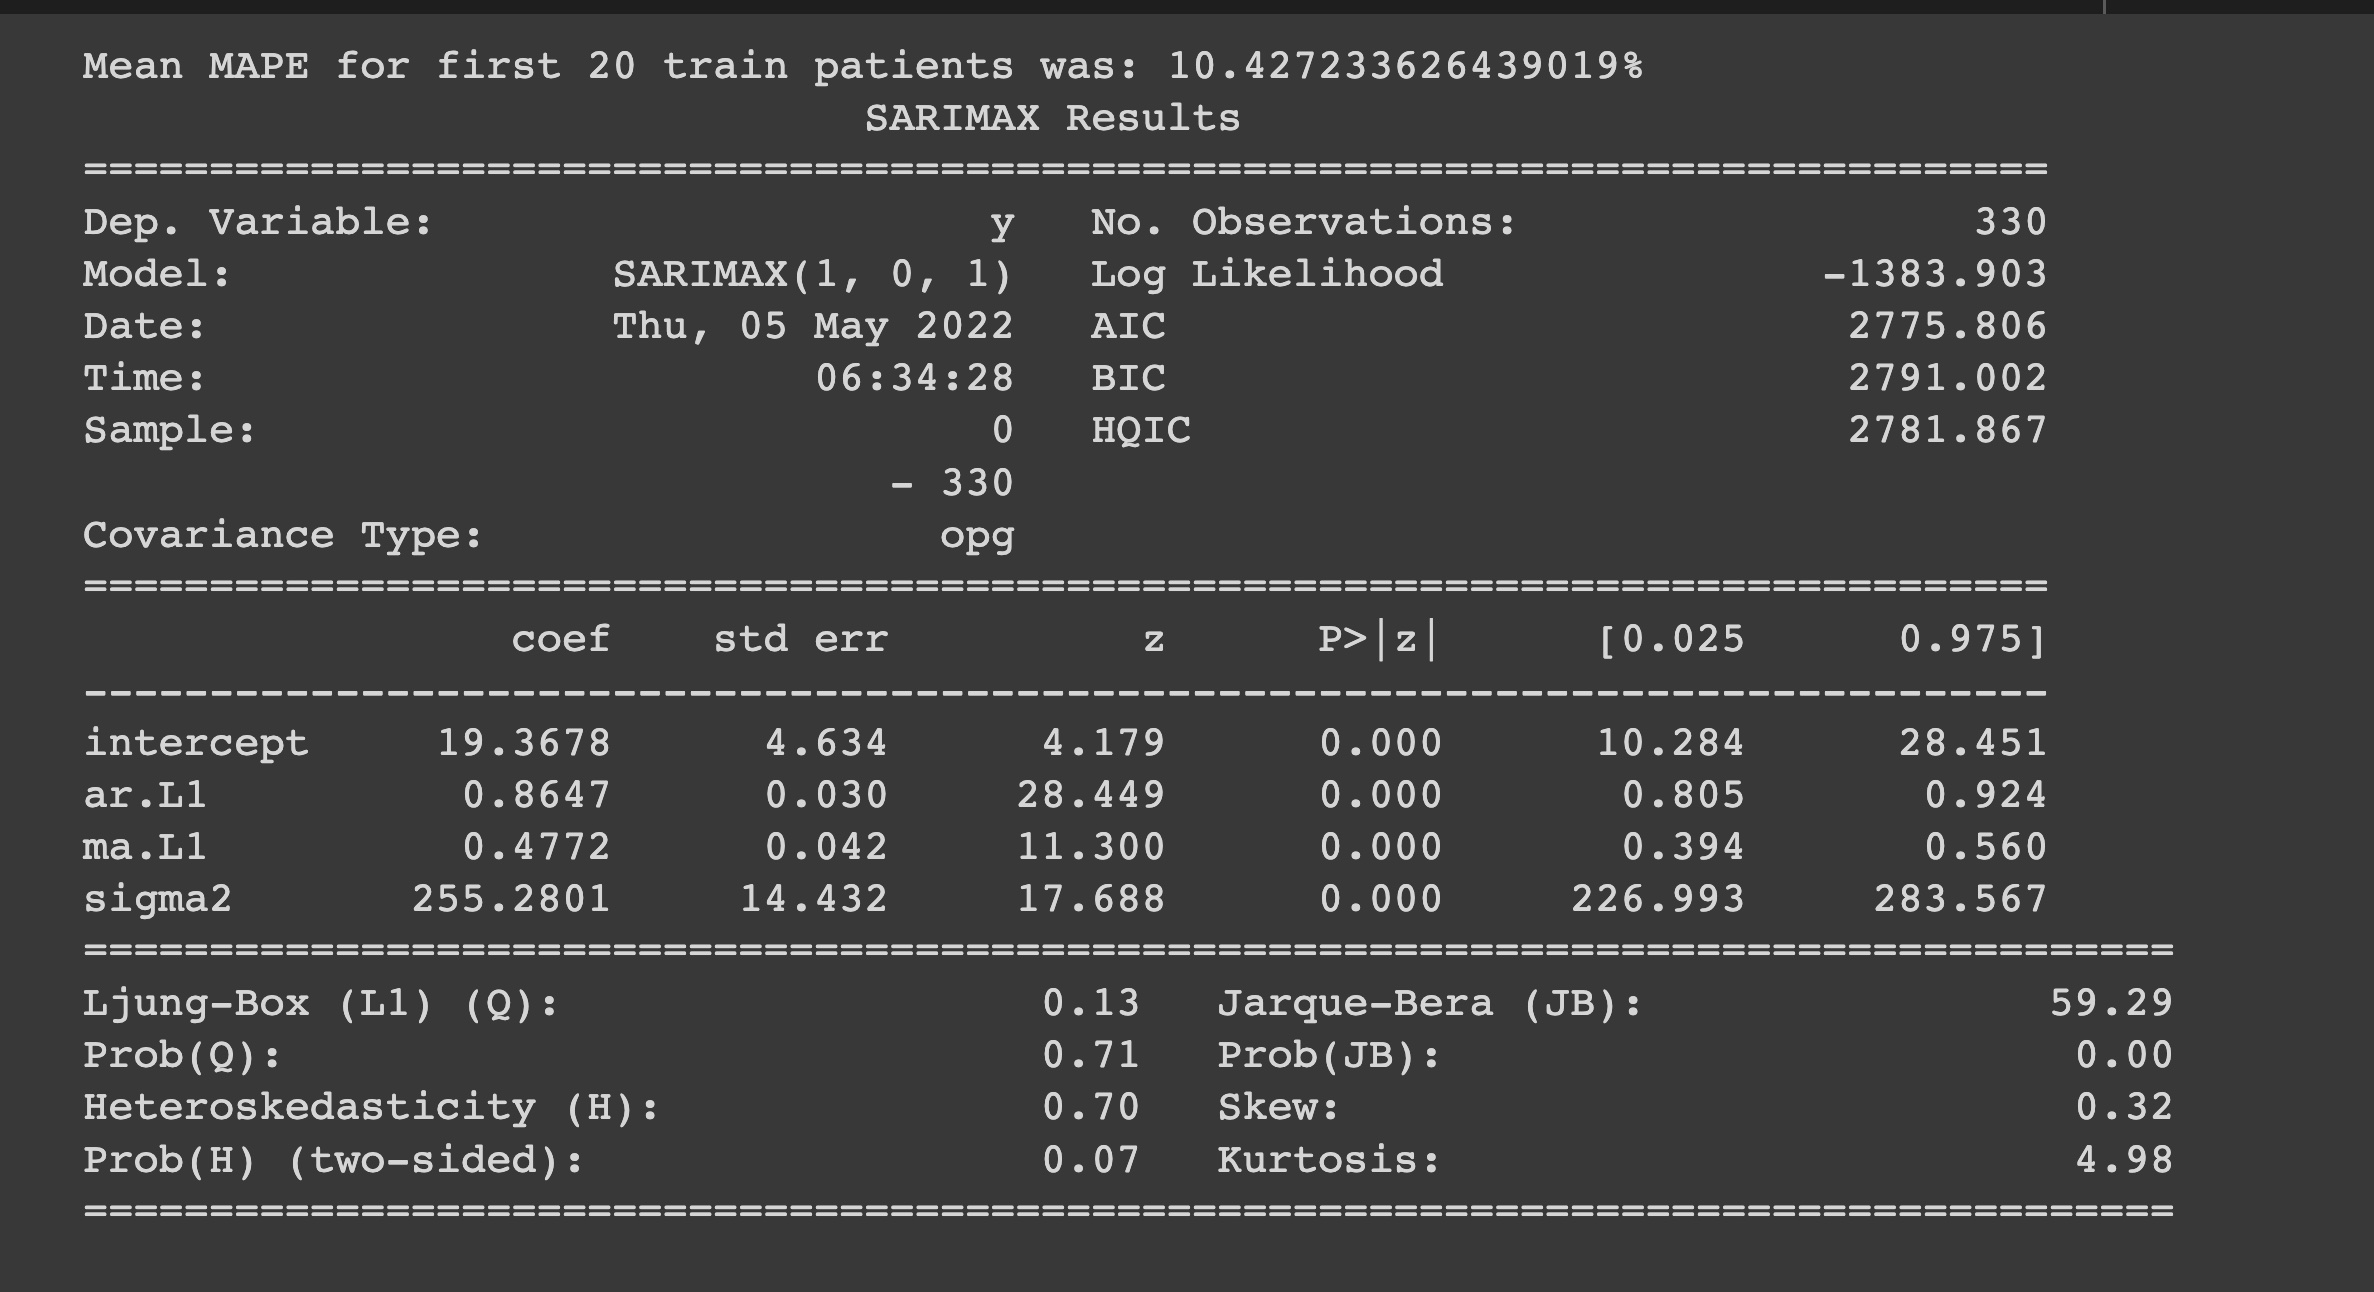

Summarizing the arima analysis, it is a bit of a different beast from other models that were tried. The MAPE (for trained data) is roughly 10.42%. However, because it is VERY fast to train an ARIMA model on a given dataset, and because THE given parameter estimates for an ARIMA(1,0,1) doesn't usually generalize super well to other time series, it actually makes the most sense to use the model produced by our SARIMAX's values for p, q, s, and d but to train the model individually per patient to get personalized SARIMA predictions. 

Future steps would be to explore multivariate relationships with other data, like insulin, with Vector Auto SARIMAX. 

## Temporal Convolutional Neural Network (TCN) 

Another forecasting model, we next explore a TCN. For a more detailed analysis and evaluation of TCN performance, please see `./TCN.ipynb` 

This model was trained with an input length of 256, dilation_base = 2, dropout=0.3, n_epochs=500, gpu acceleration. Further, to increase performance of the model, downcasting was used to downcast float64 values to float32.

One reason we chose to explore this model is, given its heirarchical stacking of dilated filters, it is highly parallelizable when compared to LSTM. This can greatly decrease training time. 

For more information on TCN's see: https://towardsdatascience.com/temporal-convolutional-networks-the-next-revolution-for-time-series-8990af826567



In [13]:
# load the model
model_path = "/content/drive/MyDrive/Colab Notebooks/glucose_prediction/models/tcn/TCN_100_epochs.pth.tar.pth.tar"
tcn_model = TCNModel.load_model(model_path)

[2022-05-05 18:00:59,786] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 2
[2022-05-05 18:00:59,786] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 2
2022-05-05 18:00:59 darts.models.forecasting.tcn_model INFO: Number of layers chosen: 2


After some testing, I noticed that the loss for 60 epochs is about the same as for ~400 or ~500. Thus, favor shorter training time.

In [ ]:
# Model Evaluation
resampled_patient_timeseries_train = [ individual_ts for individual_ts in resampled_patient_timeseries_train if len(individual_ts) > 256]
individual_resampled_patient_timeseries_test = [ individual_ts for individual_ts in resampled_patient_timeseries_test if len(individual_ts) > 256]
tcn_model = TCNModel.load_model(model_path)

# Model Evaluation: Train 
# GET MAPE and Historical Predictions
last_point_historical_predictions_train = []
train_mapes = []
for i, individual_resampled_patient_timeseries_train in enumerate(resampled_patient_timeseries_train):
  series_length = len(individual_resampled_patient_timeseries_train)
  if(series_length <= 256):
    print(f"ignored series with length  was {len(individual_resampled_patient_timeseries_train)}")
    continue

  if(i>= 20):
    break

  stride = round(len(individual_resampled_patient_timeseries_train)/10) # stride width = 1/10th the timeseries each time. 
  last_point_mape = tcn_model.backtest(individual_resampled_patient_timeseries_train, start=0.1, forecast_horizon=1, stride=stride, metric=mape, last_points_only=True, retrain=False, verbose=False)
  train_mapes.append(last_point_mape)

  # only get historical forecasts for 5 time_series for performance
  if(i< 5):
    last_point_predictions = tcn_model.historical_forecasts(individual_resampled_patient_timeseries_train, start=0.2, forecast_horizon=1, stride=1, last_points_only=True, retrain=False, verbose=False)
    last_point_historical_predictions_train.append(last_point_predictions)

# Model Evaluation: Test 
# GET MAPE and Historical Predictions
last_point_historical_predictions_test = []
test_mapes = []
for i, individual_resampled_patient_timeseries_test in enumerate(resampled_patient_timeseries_test):
  if(i>= 20):
    break

  stride = round(len(individual_resampled_patient_timeseries_test)/10) # stride width = 1/10th the timeseries each time. 
  last_point_mape = tcn_model.backtest(individual_resampled_patient_timeseries_test, start=0.5, forecast_horizon=1, stride=stride, metric=mape, last_points_only=True, retrain=False, verbose=False)
  test_mapes.append(last_point_mape)

  # only get historical forecasts for 5 time_series for performance
  if(i< 5):
    last_point_predictions = tcn_model.historical_forecasts(individual_resampled_patient_timeseries_test, start=0.5, forecast_horizon=1, stride=1, last_points_only=True, retrain=False, verbose=False)
    last_point_historical_predictions_test.append(last_point_predictions)

In [17]:
print(f"Mean Train MAPE for first 20 train patients was: {statistics.mean(train_mapes)}%")
print(f"Mean Test MAPE for first 20 test patients was: {statistics.mean(test_mapes)}%")

Mean Train MAPE for first 20 train patients was: 14.815334659069777%
Mean Test MAPE for first 20 test patients was: 14.324828628450632%


Note: There is NOT overfitting, BUT the Test Absolute Percentage Error Percentage Error is 14.324% which is not particularly good. TCN appears to act more to a kalman filter or even a low pass filter. It does NOT outperform our No Information forecasting model. 

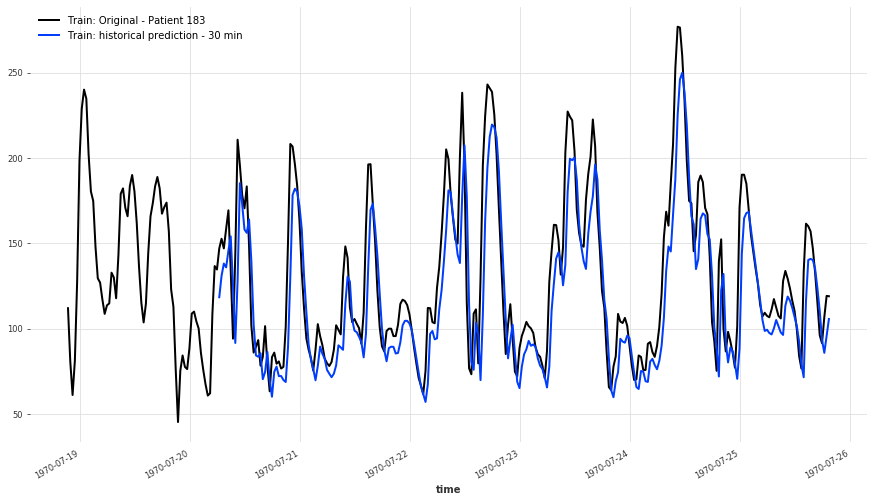

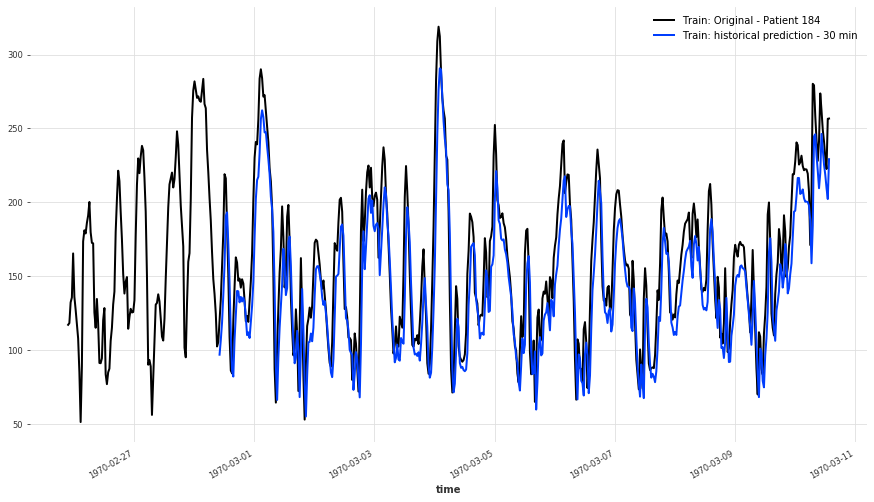

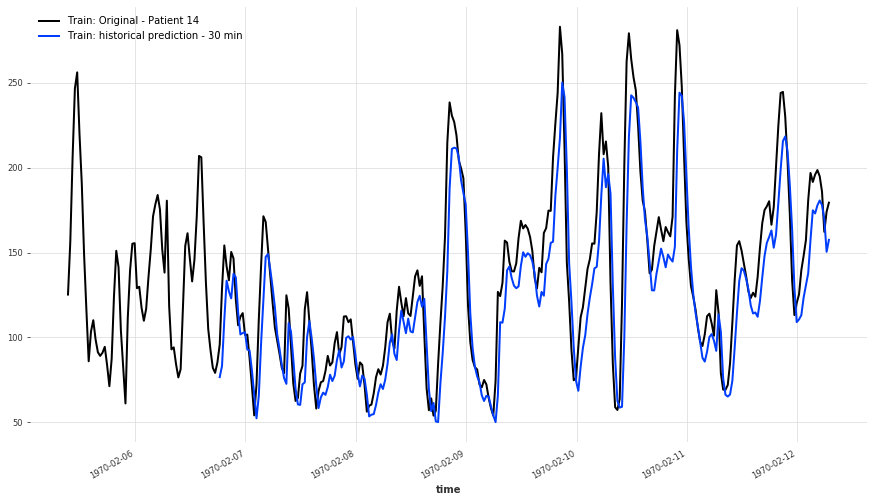

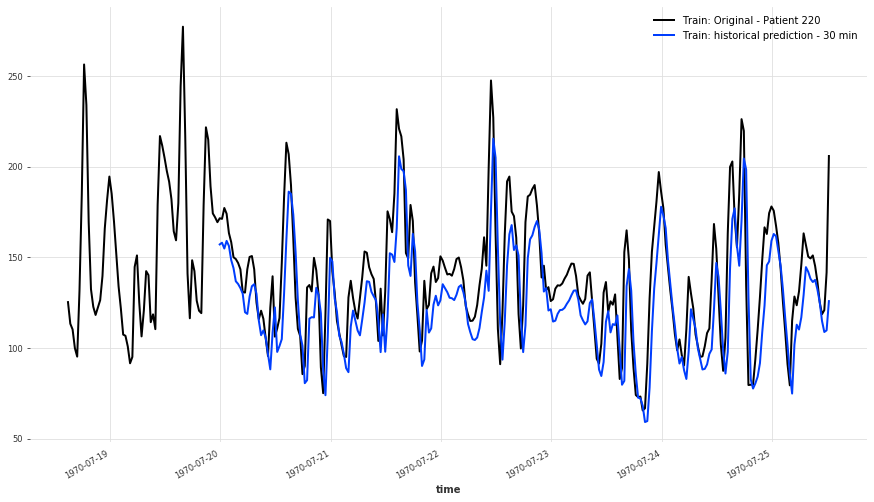

In [15]:
# TCN Train Historical Prediction plot
for patient_id_index in range(0, 4):
  plt.figure(figsize=(15,8))
  resampled_patient_timeseries_train[patient_id_index].plot(label=f"Train: Original - Patient {patient_ids[patient_id_index]}")
  last_point_historical_predictions_train[patient_id_index].plot(label="Train: historical prediction - 30 min")

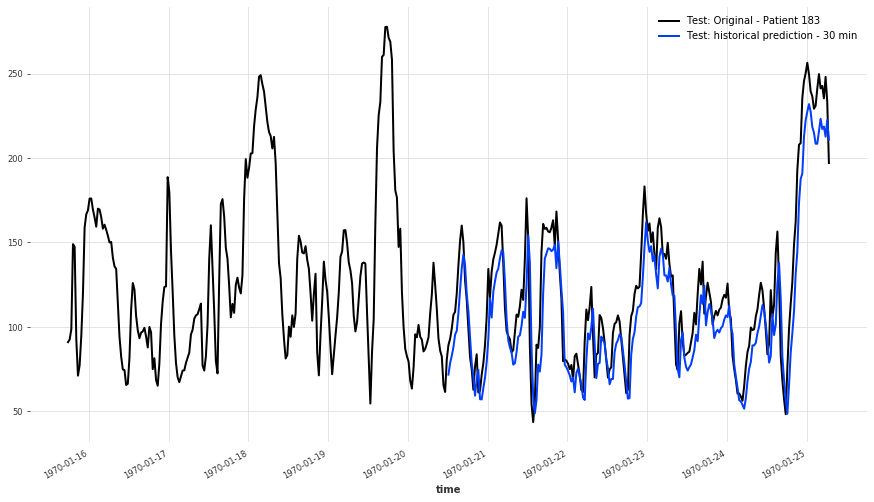

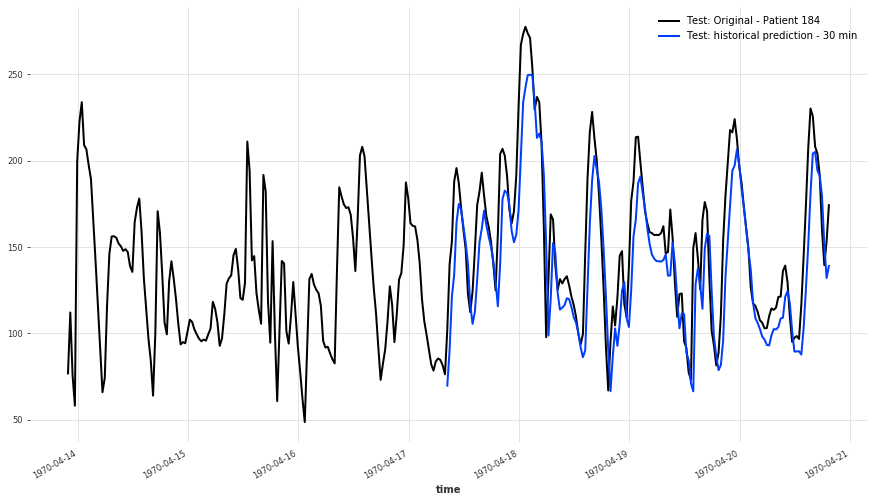

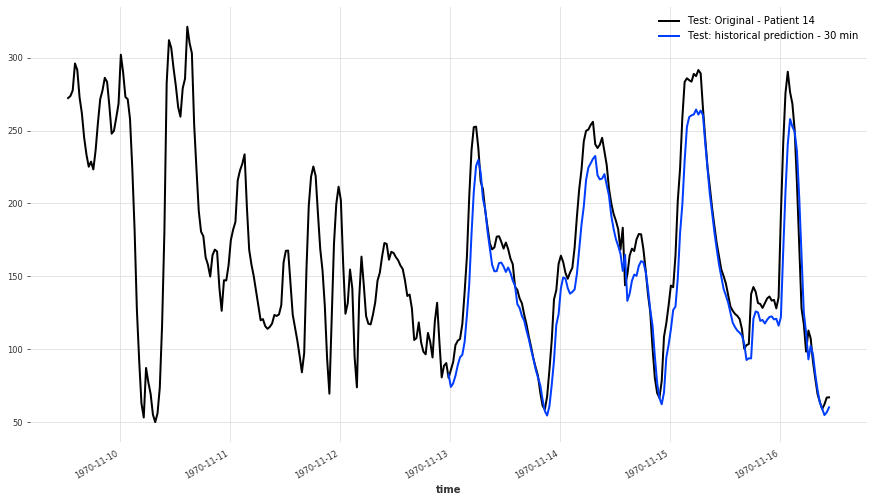

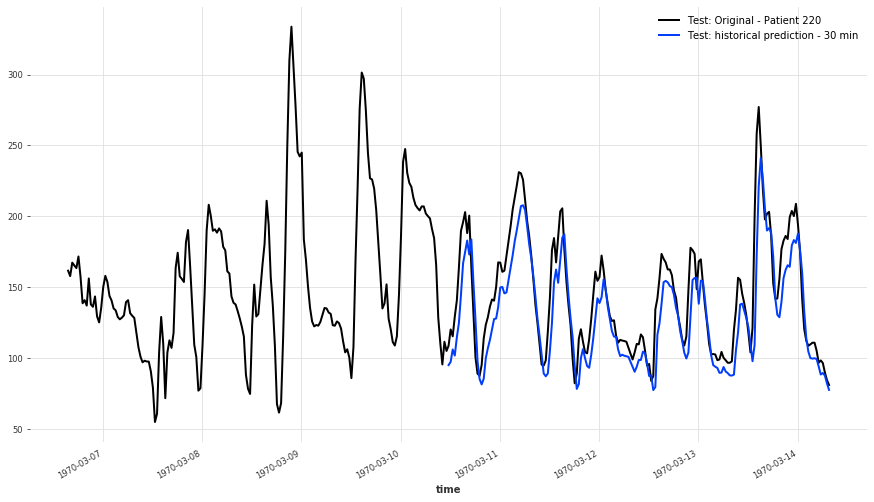

In [16]:
# TCN Test Historical Prediction plot
for patient_id_index in range(0, 4):
  plt.figure(figsize=(15,8))
  resampled_patient_timeseries_test[patient_id_index].plot(label=f"Test: Original - Patient {patient_ids[patient_id_index]}")
  last_point_historical_predictions_test[patient_id_index].plot(label="Test: historical prediction - 30 min")

Interestingly, the TCN appears to perform forecasts that predict previous values. We can see this due to the lagged nature of the forecasts in the plots above. It is essentially acting like a worse "No Information" prediction.

This algorithm currently requires 256 30-miniute samples to predict. This equates to 5.333333333333333 days worth of glucose data. (This receptive field can absolutely be tuned though)

Due to this and the smoothing or "low pass"  like behavior, and highish test MAPE, next steps would be increase the depth of the TCN by increasing the kernel size and thus increasing the receptive field, as well as tweaking learning rate. Other parameters could be investigated with a grid search too. 

IN general, this algorithm might be flawed and not worth tuning too much, but of course, that could be wrong. 

Next step: grid search best number of epochs, number of layers, chunk size, and more with a validation set (val_series in a gridsearch()) to allow for better validation so we can reduce overfitting by picking the best model hyperparameters in terms of lowest validation MAPE. Basically, pick the hyperparameters which reduce overfitting

see: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html


## NBEATS

Another forecasting model, we next explore a NBEATS model. NBEATS is another  neural network architecture detailed here: https://arxiv.org/abs/1905.10437 For a more detailed analysis and evaluation of TCN performance, please see ./NBEATS.ipynb

This model was trained with an input length of 64, n_epochs=1000, and gpu acceleration. Further, to increase performance of the model, again downcasting was used to downcast float64 values to float32.



In [4]:
model_path = "/content/drive/MyDrive/Colab Notebooks/glucose_prediction/models/nbeats/NBEATS_1K_TAIL_500_Epoch.pth.tar"
nbeats_model = NBEATSModel.load_model(model_path)

In [ ]:
# Model Evaluation: Train 
# GET MAPE and Historical Predictions
last_point_historical_predictions_train = []
train_mapes = []
for i, individual_resampled_patient_timeseries_train in enumerate(resampled_patient_timeseries_train):
  if(i>= 20):
    break

  stride = round(len(individual_resampled_patient_timeseries_train)/10) # stride width = 1/10th the timeseries each time. 
  last_point_mape = nbeats_model.backtest(individual_resampled_patient_timeseries_train, start=0.5, forecast_horizon=1, stride=stride, metric=mape, last_points_only=True, retrain=False, verbose=False)
  train_mapes.append(last_point_mape)

  # only get historical forecasts for 5 time_series for performance
  if(i< 5):
    last_point_predictions = nbeats_model.historical_forecasts(individual_resampled_patient_timeseries_train, start=0.5, forecast_horizon=1, stride=1, last_points_only=True, retrain=False, verbose=False)
    last_point_historical_predictions_train.append(last_point_predictions)

# Model Evaluation: Test 
# GET MAPE and Historical Predictions
last_point_historical_predictions_test = []
test_mapes = []
for i, individual_resampled_patient_timeseries_test in enumerate(resampled_patient_timeseries_test):
  if(i>= 20):
    break

  stride = round(len(individual_resampled_patient_timeseries_test)/10) # stride width = 1/10th the timeseries each time. 
  last_point_mape = nbeats_model.backtest(individual_resampled_patient_timeseries_test, start=0.5, forecast_horizon=1, stride=stride, metric=mape, last_points_only=True, retrain=False, verbose=False)
  test_mapes.append(last_point_mape)

  # only get historical forecasts for 5 time_series for performance
  if(i< 5):
    last_point_predictions = nbeats_model.historical_forecasts(individual_resampled_patient_timeseries_test, start=0.5, forecast_horizon=1, stride=1, last_points_only=True, retrain=False, verbose=False)
    last_point_historical_predictions_test.append(last_point_predictions)

In [10]:
print(f"Mean Train MAPE for first 20 train patients was: {statistics.mean(train_mapes)}%")
print(f"Mean Test MAPE for first 20 test patients was: {statistics.mean(test_mapes)}%")

Mean Train MAPE for first 20 train patients was: 0.4210084001533687%
Mean Test MAPE for first 20 test patients was: 11.240096911787987%


Note: There is clear overfitting! Test Absolute Percentage Error Percentage Error is >20 times the Train Mean Absolute Percentage Error. 

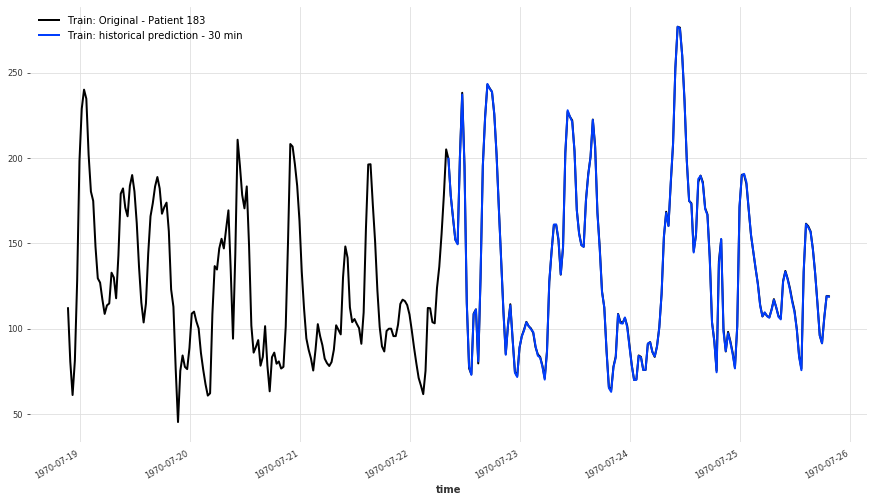

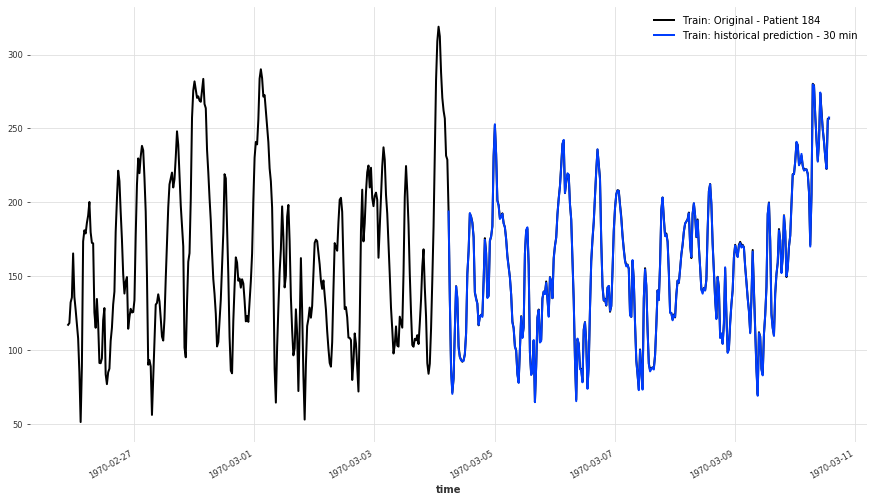

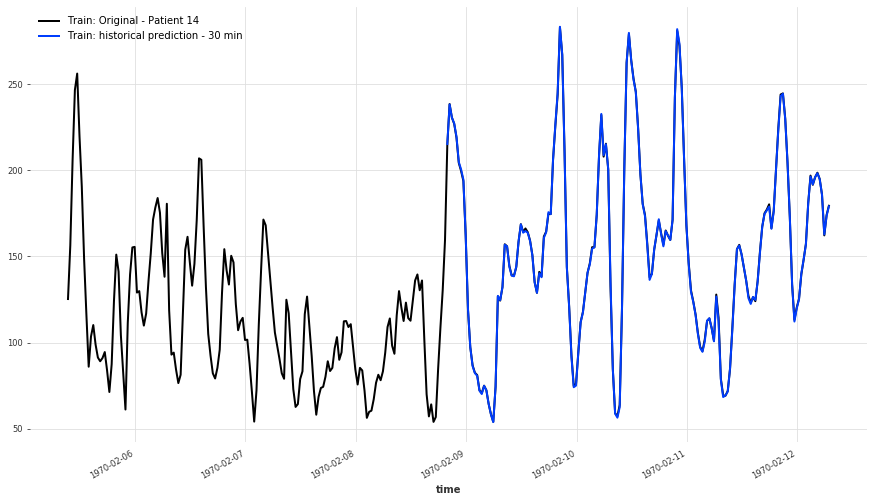

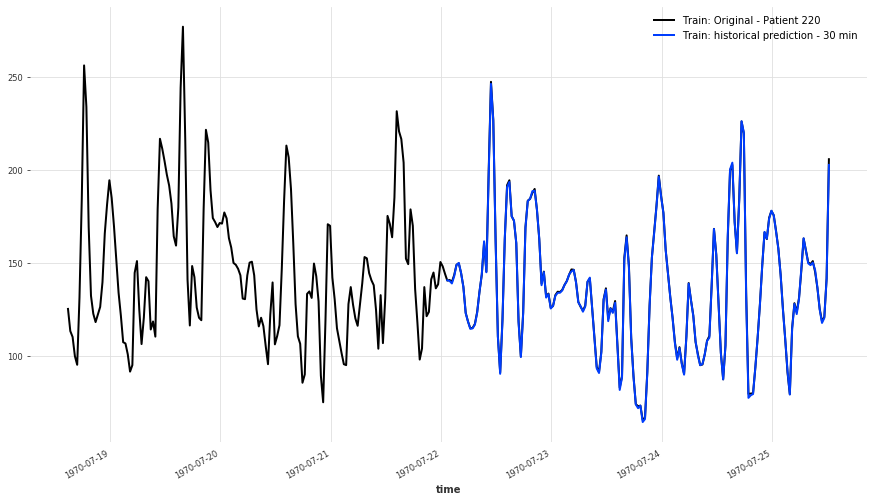

In [12]:
# Train Historical Prediction plot
for patient_id_index in range(0, 4):
  plt.figure(figsize=(15,8))
  resampled_patient_timeseries_train[patient_id_index].plot(label=f"Train: Original - Patient {patient_ids[patient_id_index]}")
  last_point_historical_predictions_train[patient_id_index].plot(label="Train: historical prediction - 30 min")

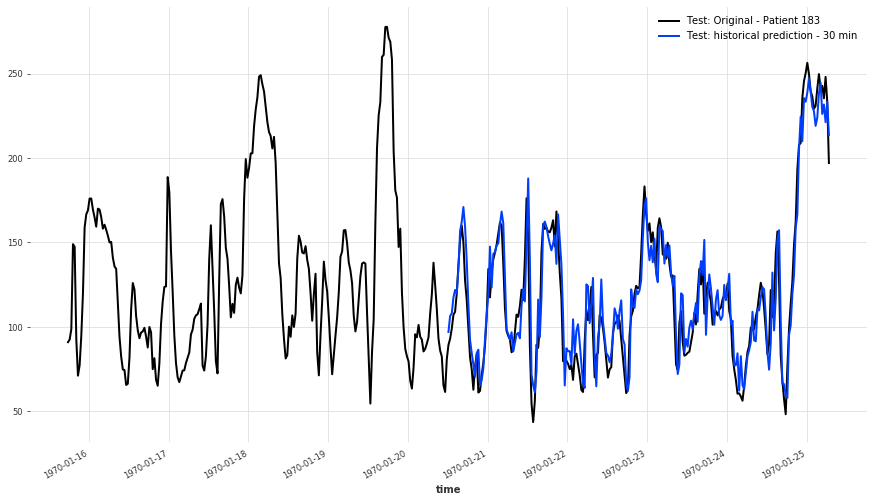

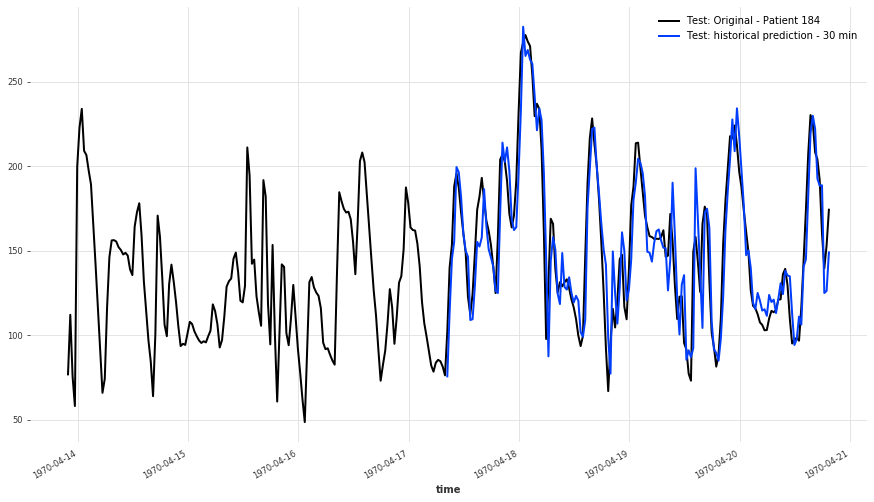

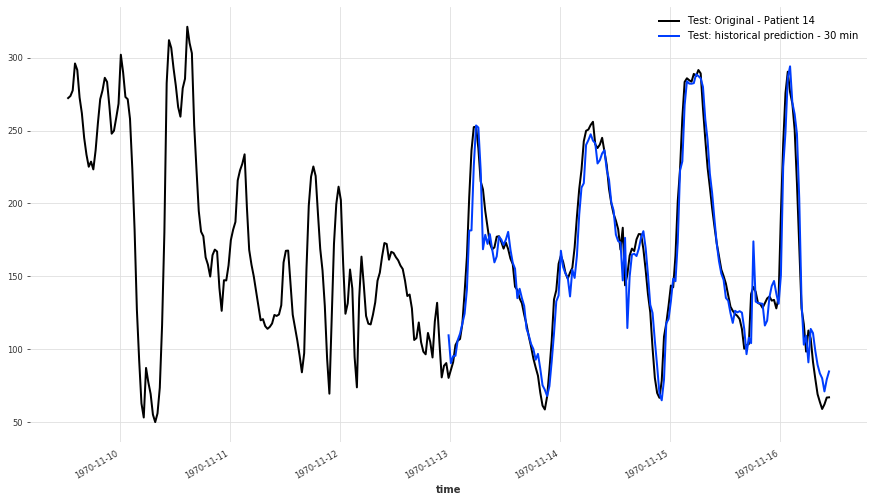

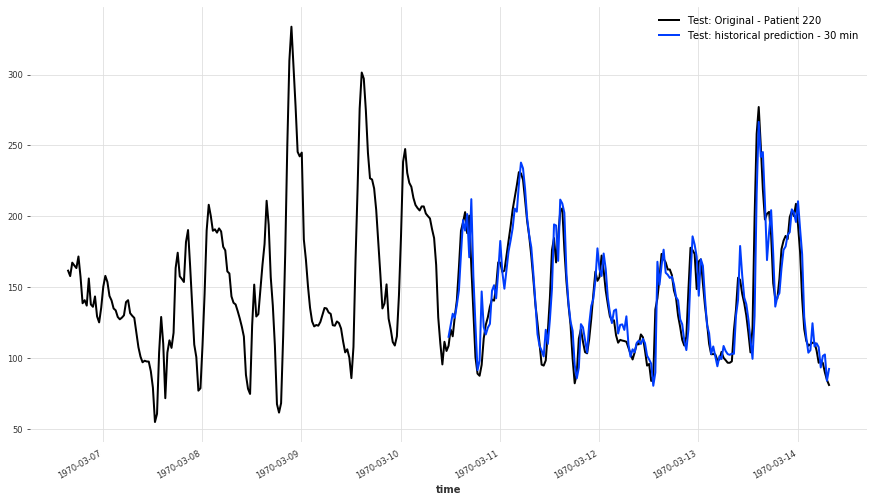

In [13]:
# Test Historical Prediction plot
for patient_id_index in range(0, 4):
  plt.figure(figsize=(15,8))
  resampled_patient_timeseries_test[patient_id_index].plot(label=f"Test: Original - Patient {patient_ids[patient_id_index]}")
  last_point_historical_predictions_test[patient_id_index].plot(label="Test: historical prediction - 30 min")

Due to the overfitting, and high test MAPE, next steps would be to introduce bias or even dropout if possible or better yet.

This algorithm currently requires 64 30-miniute samples to predict. This equates to 1 & 1/3 days worth of glucose data. (This receptive field can absolutely be tuned though)

Next step: grid search best number of epochs, number of layers, chunk size, and more with a validation set (val_series in a gridsearch()) to allow for better validation so we can reduce overfitting by picking the best model hyperparameters in terms of lowest validation MAPE. Basically, pick the hyperparameters which reduce overfitting

see: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html#darts.models.forecasting.nbeats.NBEATSModel.predict.

# Discussion
## Comparing results:

TEST Mean Absolute Percentage Error:
*   The No-Information Forecast: 12.1%
*   ARIMA(1,0,1) (personalized for each patient): 10.4%
*   TCN: 14.324%
*   NBEATS: 11.2%

We can see that none of the models currently smash the No-Information Forecast. With some hyperparameter tweaking and more time, I'm confident the MAPE for each algorithm could be brought down. Specifically, NBEATS, appears promising.  ARIMA is appealing because of it's explainability, and also its ability to performantly train for each patient's glucose data, personalizing to their meal patterns. Ultimately, 30 minutes is a short forecast window, and forecasting the current glucose value is powerful. 

With more time, or compute, we could grid search across these algorithms, AND even other models. Ensembles are also possible, although their explainability turns into a black box very quickly. Notealy, darts does perform probablistic forecasts for some models, so it might be worth exploring those instead of a hard forecast. If we did probablistic forecasts, I would recommend leveraging a log normal distribution, as that would fit the right skewedness of the glucose values. 

Other algorithms which might do well that we could explore with more time include Bi-Directional LSTM, Exponential Smoothing, Theta forecasting etc. 

In this research, we chose not to explore LSTM because of its long training overhead due to needing to unroll the network every time. 

VERY importantly, if there was more time, multivariate analysis on insulin bolus amount or insulin on board could be analyzed. Most of the algorithms looked at in this exercise can be extended to do multivariate forecasting including VARIMA, NBEATS, TCN, and models that weren't explored like LSTM as well. 

Another fast follow to performing multivariate analysis, would be to leverage shap scores for variable importance. 


